# 集成方法评估

> author: Shizhenkun   
> email: zhenkun.shi@tib.cas.cn   
> date: 2025-09-08  


## 1. Import packages

In [1]:
import sys,os
sys.path.insert(0, os.path.dirname(os.path.realpath('__file__')))
sys.path.insert(1,'../../')
from config import conf as cfg
from tqdm import tqdm
import numpy as np
from pandarallel import pandarallel # 导入pandaralle
pandarallel.initialize(progress_bar=False)
from evaluation import evTools
from joblib import parallel_backend
from multiprocessing import Pool
import itertools
import pandas as pd
from tqdm.notebook import tqdm

FIRST_TIME_RUN = False # For the initial run, please set this flag to True. This will allow the program to download data from UniProt and RHEA, which may take longer depending on your internet speed.

%load_ext autoreload
%autoreload 2

INFO: Pandarallel will run on 192 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 2. Loading test data and predictor results

In [4]:
test_set = pd.read_feather(cfg.FILE_DS_TEST)
test_set = test_set[['uniprot_id', 'reaction_id', 'ec_number', 'label']].rename(columns={'reaction_id': 'rxn_groundtruth', 'ec_number': 'ec_groundtruth', 'label': 'rxn_groundtruth_label'})

res_ec  = pd.read_feather(f'{cfg.CASE_2018LATER}res/res_methods_ec.feather')
res_ec=res_ec.rename(columns={
                        'reaction_ecblast':'rxn_ecblast',
                        'reaction_deepec':'rxn_deepec',
                        'reaction_clean':'rxn_clean',
                        'reaction_ecrecer':'rxn_ecrecer',
                        'reaction_catfam':'rxn_catfam',
                        'reaction_priam':'rxn_priam',
})
res_direct = pd.read_feather(f'{cfg.CASE_2018LATER}res/res_methods_direct.feather')

res = res_direct.merge(res_ec, on='uniprot_id', how='left')
res.head(2)

,uniprot_id,rxn_groundtruth_x,enz_groundtruth,lb_rxn_groundtruth_x,rxn_blast,lb_rxn_blast,rxn_eu_esm,enz_eu_esm,rxn_cos_esm,enz_cos_esm,...,rxn_catfam,ec_priam,rxn_priam,lb_rxn_ecblast,lb_rxn_deepec,lb_rxn_clean,lb_rxn_ecrecer,lb_rxn_ecpred,lb_rxn_catfam,lb_rxn_priam
0,A9JLI2,-,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-,0,-,0,...,-,NO-PREDICTION,NO-PREDICTION,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,A9JLI3,-,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-,0,-,0,...,-,1.14.11.51;2.3.2.27,RHEA:49524,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 3 整理计算表格

In [5]:
# 创建公共的重命名字典
rename_dict = {
    'lb_rxn_groundtruth_x': 'rxn_groundtruth',
    'lb_rxn_ecblast': 'MSA-via-EC',
    'lb_rxn_deepec': 'DeepEC',
    'lb_rxn_clean': 'CLEAN',
    'lb_rxn_ecrecer': 'ECRECer',
    'lb_rxn_catfam': 'CatFam',
    'lb_rxn_priam': 'PRIAM',
    'lb_rxn_blast': 'MSA-via-RXN',
    'lb_rxn_cos_esm': 'ESM',
    'lb_rxn_cos_unirep': 'UniRep',
    'lb_rxn_cos_t5': 'T5',
    'lb_rxn_RXNRECer': 'ESMwithCLF',
    'rxn_groundtruth_x': 'rxn_groundtruth',
    'rxn_ecblast': 'MSA-via-EC',
    'rxn_deepec': 'DeepEC',
    'rxn_clean': 'CLEAN',
    'rxn_ecrecer': 'ECRECer',
    'rxn_catfam': 'CatFam',
    'rxn_priam': 'PRIAM',
    'rxn_blast': 'MSA-via-RXN',
    'rxn_cos_esm': 'ESM',
    'rxn_cos_unirep': 'UniRep',
    'rxn_cos_t5': 'T5',
    'rxn_RXNRECer': 'ESMwithCLF'
}

# 定义 methods 列表
methods = ['MSA-via-EC', 'DeepEC', 'CLEAN', 'ECRECer', 'CatFam', 'PRIAM', 'MSA-via-RXN', 'ESM', 'UniRep', 'T5', 'ESMwithCLF']
cb_methods = ['MSA-via-EC', 'DeepEC', 'CLEAN', 'ECRECer', 'CatFam', 'PRIAM', 'MSA-via-RXN', 'ESM', 'UniRep', 'T5']
# 创建函数来生成 DataFrame
def create_dataframe(prefix, df_data):
    # 筛选以指定前缀开头的列
    selected_columns = ['uniprot_id'] + [col for col in res.columns if col.startswith(prefix)]
    # 重命名列并选择所需的列
    df = df_data[selected_columns].rename(columns=rename_dict)
    df = df[['uniprot_id', 'rxn_groundtruth'] + methods]
    return df

df_cp = create_dataframe(prefix='lb_', df_data=res)
df_cp.head(2)

,uniprot_id,rxn_groundtruth,MSA-via-EC,DeepEC,CLEAN,ECRECer,CatFam,PRIAM,MSA-via-RXN,ESM,UniRep,T5,ESMwithCLF
0,A9JLI2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,A9JLI3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 4.计算指标

### 4.1 单个预测器

In [96]:
# 定义平均类型列表
# avg_types = ['weighted', 'micro', 'macro']
avg_types = ['weighted']
eva_metrics_initial = evTools.get_metrics(pred_cols=methods, avg_types=avg_types, df=df_cp, ground_truth_col='rxn_groundtruth')
eva_metrics_initial.sort_values(by=['mF1'], ascending=[False])

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType
10,ESMwithCLF,0.598520,0.749473,0.930456,0.802831,weighted
9,T5,0.746948,0.893889,0.744800,0.778224,weighted
7,ESM,0.727414,0.884853,0.723750,0.760845,weighted
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted
8,UniRep,0.689752,0.863138,0.670040,0.712641,weighted
6,MSA-via-RXN,0.501295,0.919604,0.545669,0.642326,weighted
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted
5,PRIAM,0.017832,0.853372,0.160137,0.075407,weighted


In [ ]:
methods = ['MSA-via-EC', 'DeepEC', 'CLEAN', 'ECRECer', 'CatFam', 'PRIAM', 'MSA-via-RXN', 'ESM', 'UniRep', 'T5', 'ESMwithCLF']
df_hum = create_dataframe('rxn_', res)
for item in methods:
    df_hum[f'pred_true_{item}'] = df_hum.apply(
        lambda x: set(x.rxn_groundtruth.split(cfg.SPLITER)).issubset(set(x[f'{item}'].split(cfg.SPLITER))),
        axis=1
    )
    
for item in methods:
    correct = df_hum[df_hum[f'pred_true_{item}']].shape[0]
    accuracy = round(correct / len(df_hum), 6)
    print(f'{item:12s}: {accuracy}')
    
# evTools.calculate_metrics(eva_df=df_cp, ground_truth_col='rxn_groundtruth', pred_col='MSA-via-EC', eva_name='m', avg_method='macro')

MSA-via-EC  : 0.43744
DeepEC      : 0.036108
CLEAN       : 0.10899
ECRECer     : 0.695154
CatFam      : 0.771143
PRIAM       : 0.118461
MSA-via-RXN : 0.516907
ESM         : 0.739327
UniRep      : 0.698705
T5          : 0.760858
ESMwithCLF  : 0.957085


### 4.2  两个预测器组合

In [ ]:
cb_methods = ['MSA-via-EC', 'DeepEC', 'CLEAN', 'ECRECer', 'CatFam', 'PRIAM', 'MSA-via-RXN', 'ESM', 'UniRep', 'T5']
ensemble_metrics_2 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[1], ensemble_types=['recall_boosted', 'majority'])

计算 2 个方法的组合, 共 10 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.3 三个预测器组合

In [ ]:
ensemble_metrics_3 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[2], ensemble_types=['recall_boosted', 'majority'])

计算 3 个方法的组合, 共 45 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.4 四个预测器组合

In [ ]:
ensemble_metrics_4 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[3], ensemble_types=['recall_boosted', 'majority'])

计算 4 个方法的组合, 共 120 个
  计算 recall_boosted 集成...
  计算 majority 集成...


In [ ]:
eva_metrics = pd.concat([eva_metrics_initial, ensemble_metrics_2, ensemble_metrics_3, ensemble_metrics_4], ignore_index=True)
eva_metrics.to_feather(f'{cfg.CASE_2018LATER}res/integrate_s2_eva_metrics.feather')

### 4.5 五个预测器组合

In [ ]:
ensemble_metrics_5 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[4], ensemble_types=['recall_boosted', 'majority'])

计算 5 个方法的组合, 共 210 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.6 六个预测器组合

In [ ]:
ensemble_metrics_6 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[5], ensemble_types=['recall_boosted', 'majority'])

计算 6 个方法的组合, 共 252 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.7 七个预测器组合

In [ ]:
ensemble_metrics_7 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[6], ensemble_types=['recall_boosted', 'majority'])

计算 7 个方法的组合, 共 210 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.8 八个预测器组合

In [ ]:
ensemble_metrics_8 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[7], ensemble_types=['recall_boosted', 'majority'])

计算 8 个方法的组合, 共 120 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.9 九个预测器组合

In [ ]:
ensemble_metrics_9 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[8], ensemble_types=['recall_boosted', 'majority'])

计算 9 个方法的组合, 共 45 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.10 十个预测器组合

In [ ]:
ensemble_metrics_10 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[9], ensemble_types=['recall_boosted', 'majority'])

计算 10 个方法的组合, 共 10 个
  计算 recall_boosted 集成...
  计算 majority 集成...


### 4.11 十一个预测器组合

In [ ]:
ensemble_metrics_11 = evTools.calculate_ensemble_metrics( cb_methods=cb_methods, baseline_method='ESMwithCLF', df=df_cp, ground_truth_col='rxn_groundtruth', avg_types=['weighted'], combination_sizes=[10], ensemble_types=['recall_boosted', 'majority'])

计算 11 个方法的组合, 共 1 个
  计算 recall_boosted 集成...
  计算 majority 集成...


## 5. 分析指标

### 5.1 加载指标数据

In [ ]:
methods = ['MSA-via-EC', 'DeepEC', 'CLEAN', 'ECRECer', 'CatFam', 'PRIAM', 'MSA-via-RXN', 'ESM', 'UniRep', 'T5', 'ESMwithCLF']
eva_metrics = pd.read_excel(f'{cfg.CASE_2018LATER}res/integrate_s2_eva_metrics_0915.xlsx')
print(f'Load {eva_metrics.shape[0]} rows of eva_metrics')

# 计算mPrecision和mRecall的和
eva_metrics['sumPrecisionRecall']=eva_metrics.apply(lambda x: x['mPrecision'] + x['mRecall'], axis=1)

# 拆分ensemble_type
eva_metrics['ensemble_type'] = eva_metrics.evaName.apply(lambda x: 'majority' if '_majority' in x else ( 'recall_boosted' if '_recall_boosted' in x else '-'))
eva_metrics['evaName'] = eva_metrics.evaName.apply(lambda x: x.replace('_recall_boosted', '').replace('_majority', ''))

# 拆封集成方法
eva_metrics['ensembleMethods'] = eva_metrics.evaName.apply(lambda x: x.split('_'))
methods['ensembleNum'] = eva_metrics.ensembleMethods.apply(lambda x: len(x))


Load 2057 rows of eva_metrics


### 5.2 补充时间数据

In [157]:
run_time = {
    'MSA-via-EC': 31.50,
    'DeepEC': 4497.51,
    'CLEAN': 7744.88,
    'ECRECer': 4596.76,
    'CatFam': 1401.73,
    'PRIAM': 1095.75,
    'MSA-via-RXN': 13.77,
    'ESM': 1327.04,
    'UniRep': 3060,
    'T5': 1026.41,
    # 别名/等价映射
    'ESMwithCLF': 815.08,   # 等同 RXNRECer-S1
}
eva_metrics['run_time']=eva_metrics.ensembleMethods.apply(lambda x: sum([run_time[item] for item in x]))

In [158]:
eva_metrics

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum,run_time
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1,31.50
1,DeepEC,0.034850,0.978400,0.052406,0.059727,weighted,1.030806,-,[DeepEC],1,4497.51
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted,1.024514,-,[CLEAN],1,7744.88
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted,1.619684,-,[ECRECer],1,4596.76
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted,1.540356,-,[CatFam],1,1401.73
...,...,...,...,...,...,...,...,...,...,...,...
2052,MSA-via-EC_DeepEC_ECRECer_CatFam_PRIAM_MSA-via...,0.598594,0.749670,0.931201,0.803331,weighted,1.680871,majority,"[MSA-via-EC, DeepEC, ECRECer, CatFam, PRIAM, M...",10,17865.55
2053,MSA-via-EC_CLEAN_ECRECer_CatFam_PRIAM_MSA-via-...,0.598594,0.749651,0.931139,0.803301,weighted,1.680790,majority,"[MSA-via-EC, CLEAN, ECRECer, CatFam, PRIAM, MS...",10,21112.92
2054,DeepEC_CLEAN_ECRECer_CatFam_PRIAM_MSA-via-RXN_...,0.598594,0.749651,0.930953,0.803115,weighted,1.680604,majority,"[DeepEC, CLEAN, ECRECer, CatFam, PRIAM, MSA-vi...",10,25578.93
2055,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.086792,0.657581,0.953555,0.727407,weighted,1.611136,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",11,25610.43


In [ ]:
ss

In [114]:
def filter_best_ensemble_results(group_data, ensemble_num, target_metrics):
    """
    筛选最佳集成结果
    
    Parameters:
    - group_data: 分组后的数据
    - ensemble_num: 集成数量
    
    Returns:
    - 筛选后的DataFrame
    """
    if ensemble_num == 1:
        # 如果只有1个方法，直接返回
        return group_data
    else:
        # 如果多个方法，筛选最佳结果
        # 定义要比较的指标        
        available_metrics = [metric for metric in target_metrics if metric in group_data.columns]        
        # 找到所有达到任一指标最高值的行
        best_indices = set()        
        for metric in available_metrics:
            max_value = group_data[metric].max()
            max_indices = group_data[group_data[metric] == max_value].index.tolist()
            best_indices.update(max_indices)
        
        # 返回最佳行
        if best_indices:
            return group_data.loc[list(best_indices)]
        else:
            return group_data


def get_best_ensemble_results(eva_metrics, target_metrics):
    # 主程序
    filtered_eva_metrics = []
    for ensemble_num, group_data in eva_metrics.groupby('ensembleNum'):
        
        # 筛选该组的最佳结果
        best_group = filter_best_ensemble_results(group_data, ensemble_num, target_metrics)
        filtered_eva_metrics.append(best_group)

    res = pd.concat(filtered_eva_metrics).reset_index(drop=True)
    return res

In [107]:
# 每个组合获取指标最好的
target_metrics = ['mAccuracy', 'mPrecision', 'mRecall', 'mF1', 'sumPrecisionRecall']
eva_metrics_best = get_best_ensemble_results(eva_metrics, target_metrics)
eva_metrics_best

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1
1,DeepEC,0.034850,0.978400,0.052406,0.059727,weighted,1.030806,-,[DeepEC],1
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted,1.024514,-,[CLEAN],1
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted,1.619684,-,[ECRECer],1
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted,1.540356,-,[CatFam],1
...,...,...,...,...,...,...,...,...,...,...
320,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.598594,0.749567,0.930829,0.803019,weighted,1.680396,majority,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",10
321,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.598594,0.749586,0.930891,0.803049,weighted,1.680477,majority,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",10
322,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.598594,0.749586,0.931077,0.803235,weighted,1.680663,majority,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",10
323,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.598594,0.749643,0.931201,0.803312,weighted,1.680845,majority,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",11


In [108]:
# 每个组合获取指标最好的
target_metrics = ['mPrecision', 'mRecall']
eva_metrics_best = get_best_ensemble_results(eva_metrics, target_metrics)
eva_metrics_best

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1
1,DeepEC,0.034850,0.978400,0.052406,0.059727,weighted,1.030806,-,[DeepEC],1
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted,1.024514,-,[CLEAN],1
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted,1.619684,-,[ECRECer],1
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted,1.540356,-,[CatFam],1
5,PRIAM,0.017832,0.853372,0.160137,0.075407,weighted,1.013508,-,[PRIAM],1
6,MSA-via-RXN,0.501295,0.919604,0.545669,0.642326,weighted,1.465273,-,[MSA-via-RXN],1
7,ESM,0.727414,0.884853,0.723750,0.760845,weighted,1.608603,-,[ESM],1
8,UniRep,0.689752,0.863138,0.670040,0.712641,weighted,1.533179,-,[UniRep],1
9,T5,0.746948,0.893889,0.744800,0.778224,weighted,1.638689,-,[T5],1


In [111]:
eva_metrics_best.sort_values(by=['mF1'], ascending=[False])

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
16,ECRECer_MSA-via-RXN_ESMwithCLF,0.598890,0.753592,0.947532,0.814141,weighted,1.701124,majority,"[ECRECer, MSA-via-RXN, ESMwithCLF]",3
14,ECRECer_MSA-via-RXN_ESMwithCLF,0.598890,0.753592,0.947532,0.814141,weighted,1.701124,recall_boosted,"[ECRECer, MSA-via-RXN, ESMwithCLF]",3
17,MSA-via-EC_ECRECer_MSA-via-RXN_ESMwithCLF,0.598890,0.752997,0.947656,0.813677,weighted,1.700653,recall_boosted,"[MSA-via-EC, ECRECer, MSA-via-RXN, ESMwithCLF]",4
19,MSA-via-EC_ECRECer_CatFam_MSA-via-RXN_ESMwithCLF,0.598372,0.752375,0.947656,0.813258,weighted,1.700031,recall_boosted,"[MSA-via-EC, ECRECer, CatFam, MSA-via-RXN, ESM...",5
11,ECRECer_ESMwithCLF,0.598520,0.753080,0.946166,0.813171,weighted,1.699246,majority,"[ECRECer, ESMwithCLF]",2
12,ECRECer_ESMwithCLF,0.598520,0.753080,0.946166,0.813171,weighted,1.699246,recall_boosted,"[ECRECer, ESMwithCLF]",2
22,MSA-via-EC_ECRECer_CatFam_MSA-via-RXN_T5_ESMwi...,0.598224,0.751449,0.947718,0.812678,weighted,1.699167,recall_boosted,"[MSA-via-EC, ECRECer, CatFam, MSA-via-RXN, T5,...",6
23,CLEAN_ECRECer_PRIAM_MSA-via-RXN_ESM_T5_ESMwithCLF,0.598890,0.750694,0.934368,0.805550,weighted,1.685062,majority,"[CLEAN, ECRECer, PRIAM, MSA-via-RXN, ESM, T5, ...",7
32,DeepEC_CLEAN_ECRECer_PRIAM_MSA-via-RXN_ESM_Uni...,0.598890,0.750121,0.932257,0.804074,weighted,1.682378,majority,"[DeepEC, CLEAN, ECRECer, PRIAM, MSA-via-RXN, E...",9
31,MSA-via-EC_CLEAN_ECRECer_PRIAM_MSA-via-RXN_ESM...,0.598890,0.750121,0.932257,0.804074,weighted,1.682378,majority,"[MSA-via-EC, CLEAN, ECRECer, PRIAM, MSA-via-RX...",9


In [112]:
eva_metrics_best.sort_values(by=['mRecall'], ascending=[False])

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
38,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.086792,0.657581,0.953555,0.727407,weighted,1.611136,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",11
30,MSA-via-EC_DeepEC_CLEAN_ECRECer_PRIAM_ESM_UniR...,0.086792,0.657899,0.953555,0.727606,weighted,1.611453,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, PRIAM, ES...",9
28,DeepEC_CLEAN_ECRECer_CatFam_PRIAM_ESM_UniRep_T...,0.086792,0.657581,0.953555,0.727408,weighted,1.611136,recall_boosted,"[DeepEC, CLEAN, ECRECer, CatFam, PRIAM, ESM, U...",9
29,DeepEC_CLEAN_ECRECer_PRIAM_MSA-via-RXN_ESM_Uni...,0.086792,0.657899,0.953555,0.727606,weighted,1.611454,recall_boosted,"[DeepEC, CLEAN, ECRECer, PRIAM, MSA-via-RXN, E...",9
26,DeepEC_CLEAN_ECRECer_PRIAM_ESM_UniRep_T5_ESMwi...,0.086792,0.657899,0.953555,0.727606,weighted,1.611454,recall_boosted,"[DeepEC, CLEAN, ECRECer, PRIAM, ESM, UniRep, T...",8
33,MSA-via-EC_DeepEC_CLEAN_ECRECer_PRIAM_MSA-via-...,0.086792,0.657899,0.953555,0.727606,weighted,1.611453,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, PRIAM, MS...",10
35,DeepEC_CLEAN_ECRECer_CatFam_PRIAM_MSA-via-RXN_...,0.086792,0.657581,0.953555,0.727408,weighted,1.611136,recall_boosted,"[DeepEC, CLEAN, ECRECer, CatFam, PRIAM, MSA-vi...",10
36,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_E...,0.086792,0.657581,0.953555,0.727407,weighted,1.611136,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",10
25,CLEAN_ECRECer_PRIAM_ESM_UniRep_T5_ESMwithCLF,0.086792,0.657909,0.953493,0.727624,weighted,1.611401,recall_boosted,"[CLEAN, ECRECer, PRIAM, ESM, UniRep, T5, ESMwi...",7
24,DeepEC_CLEAN_ECRECer_PRIAM_UniRep_T5_ESMwithCLF,0.086792,0.658097,0.953493,0.727781,weighted,1.611590,recall_boosted,"[DeepEC, CLEAN, ECRECer, PRIAM, UniRep, T5, ES...",7


In [113]:
eva_metrics_best.sort_values(by=['mPrecision'], ascending=[False])

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
1,DeepEC,0.034850,0.978400,0.052406,0.059727,weighted,1.030806,-,[DeepEC],1
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted,1.619684,-,[ECRECer],1
6,MSA-via-RXN,0.501295,0.919604,0.545669,0.642326,weighted,1.465273,-,[MSA-via-RXN],1
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1
9,T5,0.746948,0.893889,0.744800,0.778224,weighted,1.638689,-,[T5],1
7,ESM,0.727414,0.884853,0.723750,0.760845,weighted,1.608603,-,[ESM],1
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted,1.024514,-,[CLEAN],1
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted,1.540356,-,[CatFam],1
8,UniRep,0.689752,0.863138,0.670040,0.712641,weighted,1.533179,-,[UniRep],1
5,PRIAM,0.017832,0.853372,0.160137,0.075407,weighted,1.013508,-,[PRIAM],1


### 获取mRecall 最好的数据

In [124]:
# 每个组合获取指标最好的
eva_metrics_best_mPrecision = get_best_ensemble_results(eva_metrics, ['mPrecision']).drop_duplicates(subset=['mPrecision']).reset_index(drop=True)
eva_metrics_best_mPrecision.sort_values(by=['mPrecision'], ascending=[False])

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
1,DeepEC,0.034850,0.978400,0.052406,0.059727,weighted,1.030806,-,[DeepEC],1
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted,1.619684,-,[ECRECer],1
6,MSA-via-RXN,0.501295,0.919604,0.545669,0.642326,weighted,1.465273,-,[MSA-via-RXN],1
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1
9,T5,0.746948,0.893889,0.744800,0.778224,weighted,1.638689,-,[T5],1
7,ESM,0.727414,0.884853,0.723750,0.760845,weighted,1.608603,-,[ESM],1
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted,1.024514,-,[CLEAN],1
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted,1.540356,-,[CatFam],1
8,UniRep,0.689752,0.863138,0.670040,0.712641,weighted,1.533179,-,[UniRep],1
5,PRIAM,0.017832,0.853372,0.160137,0.075407,weighted,1.013508,-,[PRIAM],1


In [126]:
# 每个组合获取指标最好的
eva_metrics_best_mF1 = get_best_ensemble_results(eva_metrics, ['mF1']).drop_duplicates(subset=['mF1'])
eva_metrics_best_mF1.sort_values(by=['mF1'], ascending=[False]).reset_index(drop=True)

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum
0,ECRECer_MSA-via-RXN_ESMwithCLF,0.598890,0.753592,0.947532,0.814141,weighted,1.701124,recall_boosted,"[ECRECer, MSA-via-RXN, ESMwithCLF]",3
1,ECRECer_CatFam_MSA-via-RXN_ESMwithCLF,0.598372,0.752944,0.947532,0.813703,weighted,1.700475,recall_boosted,"[ECRECer, CatFam, MSA-via-RXN, ESMwithCLF]",4
2,MSA-via-EC_ECRECer_CatFam_MSA-via-RXN_ESMwithCLF,0.598372,0.752375,0.947656,0.813258,weighted,1.700031,recall_boosted,"[MSA-via-EC, ECRECer, CatFam, MSA-via-RXN, ESM...",5
3,ECRECer_ESMwithCLF,0.598520,0.753080,0.946166,0.813171,weighted,1.699246,majority,"[ECRECer, ESMwithCLF]",2
4,MSA-via-EC_ECRECer_CatFam_MSA-via-RXN_T5_ESMwi...,0.598224,0.751449,0.947718,0.812678,weighted,1.699167,recall_boosted,"[MSA-via-EC, ECRECer, CatFam, MSA-via-RXN, T5,...",6
5,MSA-via-EC_ECRECer_CatFam_MSA-via-RXN_ESM_T5_E...,0.597410,0.750623,0.947780,0.812033,weighted,1.698403,recall_boosted,"[MSA-via-EC, ECRECer, CatFam, MSA-via-RXN, ESM...",7
6,MSA-via-EC_DeepEC_ECRECer_CatFam_MSA-via-RXN_E...,0.595043,0.748999,0.948153,0.810792,weighted,1.697152,recall_boosted,"[MSA-via-EC, DeepEC, ECRECer, CatFam, MSA-via-...",8
7,CLEAN_ECRECer_CatFam_PRIAM_MSA-via-RXN_ESM_Uni...,0.598890,0.750117,0.932257,0.804074,weighted,1.682374,majority,"[CLEAN, ECRECer, CatFam, PRIAM, MSA-via-RXN, E...",9
8,MSA-via-EC_DeepEC_CLEAN_ECRECer_PRIAM_MSA-via-...,0.598594,0.749674,0.931201,0.803336,weighted,1.680875,majority,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, PRIAM, MS...",10
9,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.598594,0.749643,0.931201,0.803312,weighted,1.680845,majority,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",11


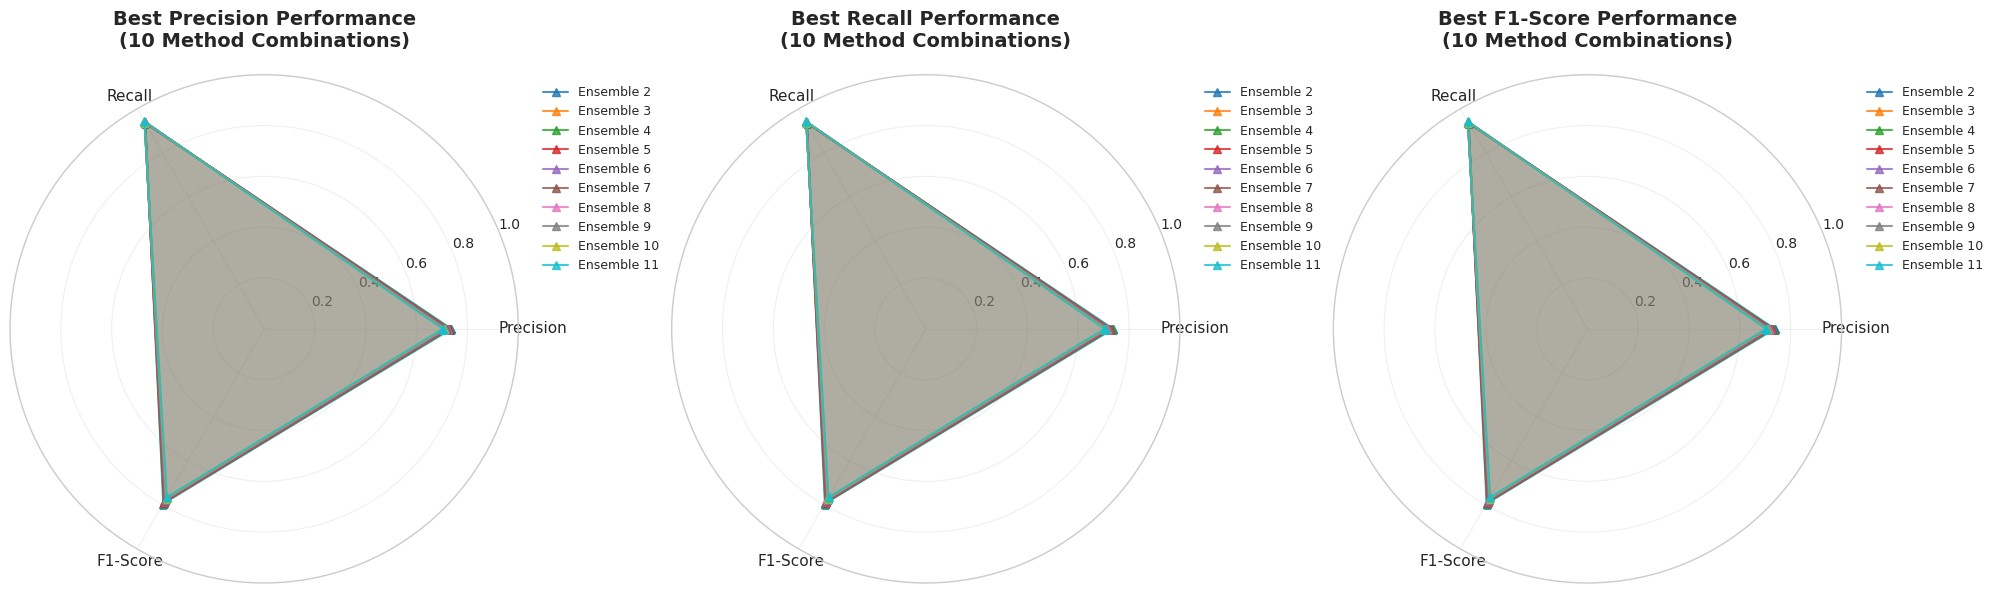

前10个方法组合详情:

Ensemble 2:
  方法数量: 20
  平均 Precision: 0.7364
  平均 Recall: 0.9350
  平均 F1-Score: 0.7937
  平均 Sum Score: 1.6715

Ensemble 3:
  方法数量: 90
  平均 Precision: 0.7244
  平均 Recall: 0.9388
  平均 F1-Score: 0.7848
  平均 Sum Score: 1.6631

Ensemble 4:
  方法数量: 240
  平均 Precision: 0.7311
  平均 Recall: 0.9372
  平均 F1-Score: 0.7898
  平均 Sum Score: 1.6683

Ensemble 5:
  方法数量: 420
  平均 Precision: 0.7257
  平均 Recall: 0.9392
  平均 F1-Score: 0.7859
  平均 Sum Score: 1.6650

Ensemble 6:
  方法数量: 504
  平均 Precision: 0.7217
  平均 Recall: 0.9391
  平均 F1-Score: 0.7818
  平均 Sum Score: 1.6608

Ensemble 7:
  方法数量: 420
  平均 Precision: 0.7174
  平均 Recall: 0.9404
  平均 F1-Score: 0.7783
  平均 Sum Score: 1.6578

Ensemble 8:
  方法数量: 240
  平均 Precision: 0.7134
  平均 Recall: 0.9407
  平均 F1-Score: 0.7745
  平均 Sum Score: 1.6542

Ensemble 9:
  方法数量: 90
  平均 Precision: 0.7099
  平均 Recall: 0.9416
  平均 F1-Score: 0.7714
  平均 Sum Score: 1.6515

Ensemble 10:
  方法数量: 20
  平均 Precision: 0.7066
  平均 Recall: 0.9419
  平均 F1-Score: 0.76

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_radar_subplot(ax, data, title, categories, ensemble_nums):
    """创建单个雷达图子图，显示多个方法组合"""
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    # 定义颜色
    colors = plt.cm.tab10(np.linspace(0, 1, len(ensemble_nums)))
    
    # 为每个方法组合绘制雷达图
    for i, ensemble_num in enumerate(ensemble_nums):
        group_data = data[data['ensembleNum'] == ensemble_num]
        if len(group_data) == 0:
            continue
            
        # 获取该组合的3个指标值
        values = [group_data['mPrecision'].mean(), 
                 group_data['mRecall'].mean(), 
                 group_data['mF1'].mean()]
        values += values[:1]  # 闭合图形
        
        # 绘制雷达图（三角形标记）
        ax.plot(angles, values, '^-', linewidth=1.5, 
               color=colors[i], markersize=6, alpha=0.8,
               label=f'Ensemble {ensemble_num}')
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # 设置图形属性
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    
    # 添加图例
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)

# 创建3个子图
fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection='polar'))

# 定义3个指标
metrics = ['mPrecision', 'mRecall', 'mF1']
metric_names = ['Precision', 'Recall', 'F1-Score']

# 过滤 ensembleNum >= 2 的数据
filtered_data = eva_metrics[eva_metrics['ensembleNum'] >= 2]

# 获取前10个方法组合
ensemble_nums = sorted(filtered_data['ensembleNum'].unique())[:10]

# 为每个指标创建子图
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    
    # 创建子图
    create_radar_subplot(ax, filtered_data, 
                        f'Best {metric_name} Performance\n(10 Method Combinations)',
                        metric_names, ensemble_nums)

# 调整布局
plt.tight_layout()
plt.savefig('best_metrics_radar_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('best_metrics_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 显示前10个方法组合的详细信息
print("前10个方法组合详情:")
print("=" * 60)
for ensemble_num in ensemble_nums:
    group_data = filtered_data[filtered_data['ensembleNum'] == ensemble_num]
    if len(group_data) > 0:
        print(f"\nEnsemble {ensemble_num}:")
        print(f"  方法数量: {len(group_data)}")
        print(f"  平均 Precision: {group_data['mPrecision'].mean():.4f}")
        print(f"  平均 Recall: {group_data['mRecall'].mean():.4f}")
        print(f"  平均 F1-Score: {group_data['mF1'].mean():.4f}")
        print(f"  平均 Sum Score: {group_data['sumPrecisionRecall'].mean():.4f}")

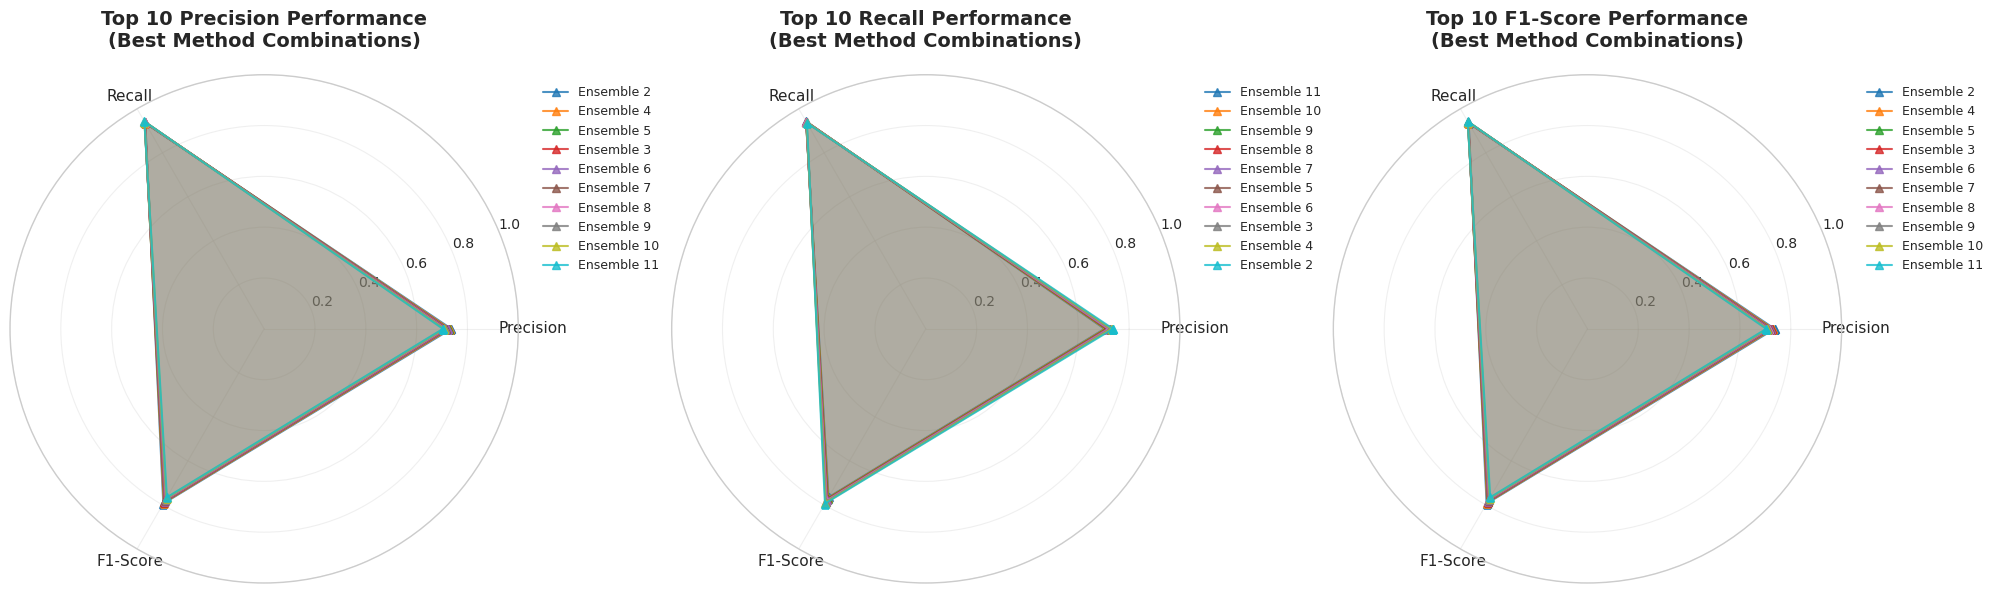

各指标前10个最佳方法组合:

Precision 前10名:
   1. Ensemble  2: 0.7364 (方法数: 20)
   2. Ensemble  4: 0.7311 (方法数: 240)
   3. Ensemble  5: 0.7257 (方法数: 420)
   4. Ensemble  3: 0.7244 (方法数: 90)
   5. Ensemble  6: 0.7217 (方法数: 504)
   6. Ensemble  7: 0.7174 (方法数: 420)
   7. Ensemble  8: 0.7134 (方法数: 240)
   8. Ensemble  9: 0.7099 (方法数: 90)
   9. Ensemble 10: 0.7066 (方法数: 20)
  10. Ensemble 11: 0.7036 (方法数: 2)

Recall 前10名:
   1. Ensemble 11: 0.9424 (方法数: 2)
   2. Ensemble 10: 0.9419 (方法数: 20)
   3. Ensemble  9: 0.9416 (方法数: 90)
   4. Ensemble  8: 0.9407 (方法数: 240)
   5. Ensemble  7: 0.9404 (方法数: 420)
   6. Ensemble  5: 0.9392 (方法数: 420)
   7. Ensemble  6: 0.9391 (方法数: 504)
   8. Ensemble  3: 0.9388 (方法数: 90)
   9. Ensemble  4: 0.9372 (方法数: 240)
  10. Ensemble  2: 0.9350 (方法数: 20)

F1-Score 前10名:
   1. Ensemble  2: 0.7937 (方法数: 20)
   2. Ensemble  4: 0.7898 (方法数: 240)
   3. Ensemble  5: 0.7859 (方法数: 420)
   4. Ensemble  3: 0.7848 (方法数: 90)
   5. Ensemble  6: 0.7818 (方法数: 504)
   6. Ensemble  7: 0.7783 (

In [135]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_radar_subplot(ax, data, title, categories, ensemble_nums, metric_name):
    """创建单个雷达图子图，显示指定指标的最佳方法组合"""
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形
    
    # 定义颜色
    colors = plt.cm.tab10(np.linspace(0, 1, len(ensemble_nums)))
    
    # 为每个方法组合绘制雷达图
    for i, ensemble_num in enumerate(ensemble_nums):
        group_data = data[data['ensembleNum'] == ensemble_num]
        if len(group_data) == 0:
            continue
            
        # 获取该组合的3个指标值
        values = [group_data['mPrecision'].mean(), 
                 group_data['mRecall'].mean(), 
                 group_data['mF1'].mean()]
        values += values[:1]  # 闭合图形
        
        # 绘制雷达图（三角形标记）
        ax.plot(angles, values, '^-', linewidth=1.5, 
               color=colors[i], markersize=6, alpha=0.8,
               label=f'Ensemble {ensemble_num}')
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    # 设置图形属性
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)
    
    # 添加图例
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=9)

# 创建3个子图
fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection='polar'))

# 定义3个指标
metrics = ['mPrecision', 'mRecall', 'mF1']
metric_names = ['Precision', 'Recall', 'F1-Score']

# 过滤 ensembleNum >= 2 的数据
filtered_data = eva_metrics[eva_metrics['ensembleNum'] >= 2]

# 为每个指标创建子图
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    
    # 按该指标排序，选择前10个最佳组合
    ensemble_performance = filtered_data.groupby('ensembleNum')[metric].mean().sort_values(ascending=False)
    top_10_ensembles = ensemble_performance.head(10).index.tolist()
    
    # 创建子图
    create_radar_subplot(ax, filtered_data, 
                        f'Top 10 {metric_name} Performance\n(Best Method Combinations)',
                        metric_names, top_10_ensembles, metric_name)

# 调整布局
plt.tight_layout()
plt.savefig('best_metrics_radar_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('best_metrics_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 显示每个指标的前10个最佳组合
print("各指标前10个最佳方法组合:")
print("=" * 60)
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    print(f"\n{metric_name} 前10名:")
    ensemble_performance = filtered_data.groupby('ensembleNum')[metric].mean().sort_values(ascending=False)
    top_10_ensembles = ensemble_performance.head(10)
    
    for rank, (ensemble_num, score) in enumerate(top_10_ensembles.items(), 1):
        group_data = filtered_data[filtered_data['ensembleNum'] == ensemble_num]
        print(f"  {rank:2d}. Ensemble {ensemble_num:2d}: {score:.4f} (方法数: {len(group_data)})")

In [191]:
# Plotly box plot: mPrecision by ensembleNum (11 groups)
import plotly.express as px


# 1) Prepare data: keep only rows with valid ensembleNum and mPrecision
_df = eva_metrics.copy()
_df = _df[_df['ensembleNum'].notna() & _df['mPrecision'].notna()]

# Choose exactly 11 groups (sorted by ensembleNum)
ensemble_groups = sorted(pd.unique(_df['ensembleNum']))[:11]
_df = _df[_df['ensembleNum'].isin(ensemble_groups)].copy()

# Ensure categorical ordering on x-axis
_df['ensembleNum'] = pd.Categorical(_df['ensembleNum'], categories=ensemble_groups, ordered=True)

# 2) Base box (single box per group). We'll overlay colored points only.
fig = px.box(
    _df,
    x='ensembleNum',
    y='mPrecision',
    points=False,
    template='simple_white',
)
fig.update_traces(line=dict(width=1.2, color='#2F4A6D'), fillcolor='rgba(76,120,168,0.10)')

# 3) Overlay jitter points colored by ensemble_type (majority vs recall_boosted)
import plotly.graph_objects as go
color_map = {'majority': '#1f77b4', 'recall_boosted': '#ff7f0e', '-': '#4C78A8'}

# overlay points centered at each category (no horizontal jitter)
if 'ensemble_type' in _df.columns:
    for etype in ['majority', 'recall_boosted', '-']:
        d = _df[_df['ensemble_type'] == etype]
        if len(d) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=d['ensembleNum'],
            y=d['mPrecision'],
            mode='markers',
            marker=dict(size=3, opacity=0.6, color=color_map.get(etype, '#4C78A8')),
            name=etype,
            showlegend=True,
        ))
else:
    fig.add_trace(go.Scatter(
        x=_df['ensembleNum'],
        y=_df['mPrecision'],
        mode='markers',
        marker=dict(size=3, opacity=0.6, color='#4C78A8'),
        name='points',
        showlegend=False,
    ))

# 4) Layout
fig.update_layout(
    title_text='mPrecision by Ensemble Number',
    title_x=0.02,
    width=1200,
    height=520,
    xaxis_title='Ensemble Number',
    yaxis_title='mPrecision',
    legend_title_text='Ensemble Type' if 'ensemble_type' in _df.columns else None,
    font=dict(size=14),
    margin=dict(l=60, r=20, t=60, b=60),
)

fig.update_yaxes(range=[0.5,  1.2], gridcolor='rgba(0,0,0,0.08)')
fig.update_xaxes(showgrid=True, gridcolor='rgba(0,0,0,0.06)')

fig.show()

# Optional: quick summary table by group (mean ± std)
summary_tbl = (
    _df.groupby('ensembleNum')['mPrecision']
      .agg(['count','mean','std'])
      .round({'mean': 4, 'std': 4})
)
print('mPrecision summary by ensembleNum (count, mean, std):')
print(summary_tbl)



mPrecision summary by ensembleNum (count, mean, std):
             count    mean     std
ensembleNum                       
1               11  0.9011  0.0405
2               20  0.7364  0.0227
3               90  0.7244  0.0275
4              240  0.7311  0.0272
5              420  0.7257  0.0304
6              504  0.7217  0.0337
7              420  0.7174  0.0365
8              240  0.7134  0.0390
9               90  0.7099  0.0416
10              20  0.7066  0.0448
11               2  0.7036  0.0651


In [168]:
2047*2

4094

In [164]:
eva_metrics['mset']=eva_metrics.ensembleMethods.apply(lambda x: set(x))
eva_metrics

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum,run_time,mset
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1,31.50,{MSA-via-EC}
1,DeepEC,0.034850,0.978400,0.052406,0.059727,weighted,1.030806,-,[DeepEC],1,4497.51,{DeepEC}
2,CLEAN,0.078949,0.879031,0.145483,0.097747,weighted,1.024514,-,[CLEAN],1,7744.88,{CLEAN}
3,ECRECer,0.689900,0.967961,0.651723,0.714824,weighted,1.619684,-,[ECRECer],1,4596.76,{ECRECer}
4,CatFam,0.770477,0.870005,0.670351,0.620349,weighted,1.540356,-,[CatFam],1,1401.73,{CatFam}
...,...,...,...,...,...,...,...,...,...,...,...,...
2052,MSA-via-EC_DeepEC_ECRECer_CatFam_PRIAM_MSA-via...,0.598594,0.749670,0.931201,0.803331,weighted,1.680871,majority,"[MSA-via-EC, DeepEC, ECRECer, CatFam, PRIAM, M...",10,17865.55,"{ECRECer, MSA-via-RXN, T5, ESM, UniRep, CatFam..."
2053,MSA-via-EC_CLEAN_ECRECer_CatFam_PRIAM_MSA-via-...,0.598594,0.749651,0.931139,0.803301,weighted,1.680790,majority,"[MSA-via-EC, CLEAN, ECRECer, CatFam, PRIAM, MS...",10,21112.92,"{MSA-via-RXN, T5, ESM, UniRep, CatFam, MSA-via..."
2054,DeepEC_CLEAN_ECRECer_CatFam_PRIAM_MSA-via-RXN_...,0.598594,0.749651,0.930953,0.803115,weighted,1.680604,majority,"[DeepEC, CLEAN, ECRECer, CatFam, PRIAM, MSA-vi...",10,25578.93,"{ECRECer, MSA-via-RXN, T5, ESM, UniRep, CatFam..."
2055,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.086792,0.657581,0.953555,0.727407,weighted,1.611136,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",11,25610.43,"{ECRECer, MSA-via-RXN, T5, ESM, UniRep, CatFam..."


In [173]:
pd.set_option('display.max_rows', 100)
eva_metrics.sort_values(by=['ensembleNum'], ascending=[True])

,evaName,mAccuracy,mPrecision,mRecall,mF1,avgType,sumPrecisionRecall,ensemble_type,ensembleMethods,ensembleNum,run_time,mset
0,MSA-via-EC,0.433370,0.907868,0.409190,0.504355,weighted,1.317058,-,[MSA-via-EC],1,31.50,{MSA-via-EC}
10,ESMwithCLF,0.834686,0.893958,0.818363,0.805957,weighted,1.712321,-,[ESMwithCLF],1,815.08,{ESMwithCLF}
8,UniRep,0.689752,0.863138,0.670040,0.712641,weighted,1.533179,-,[UniRep],1,3060.00,{UniRep}
7,ESM,0.727414,0.884853,0.723750,0.760845,weighted,1.608603,-,[ESM],1,1327.04,{ESM}
6,MSA-via-RXN,0.501295,0.919604,0.545669,0.642326,weighted,1.465273,-,[MSA-via-RXN],1,13.77,{MSA-via-RXN}
...,...,...,...,...,...,...,...,...,...,...,...,...
2037,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.086792,0.657780,0.953493,0.727582,weighted,1.611272,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",10,24283.39,"{ECRECer, MSA-via-RXN, T5, UniRep, CatFam, MSA..."
2036,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.094414,0.669021,0.953120,0.735375,weighted,1.622141,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",10,22550.43,"{ECRECer, MSA-via-RXN, T5, ESM, CatFam, MSA-vi..."
2044,DeepEC_CLEAN_ECRECer_CatFam_PRIAM_MSA-via-RXN_...,0.086792,0.657581,0.953555,0.727408,weighted,1.611136,recall_boosted,"[DeepEC, CLEAN, ECRECer, CatFam, PRIAM, MSA-vi...",10,25578.93,"{ECRECer, MSA-via-RXN, T5, ESM, UniRep, CatFam..."
2055,MSA-via-EC_DeepEC_CLEAN_ECRECer_CatFam_PRIAM_M...,0.086792,0.657581,0.953555,0.727407,weighted,1.611136,recall_boosted,"[MSA-via-EC, DeepEC, CLEAN, ECRECer, CatFam, P...",11,25610.43,"{ECRECer, MSA-via-RXN, T5, ESM, UniRep, CatFam..."
